# Анализ системы метрик приложения

Procrastinate Pro+ - приложение, которое предоставляет пользователям доступ к развлекательному контенту: видео, подкастам и блогам. Пользователи могут выбрать несколько пакетов контента. Пакеты различаются по цене, объёму и содержанию.

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни.

К запуску нового контента была скорректирована маркетинговая стратегия привлечения пользователей. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели).

После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать. Нужно разобраться, почему это происходит.

Задачи:
- провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- разобраться в причинах стагнации выручки;
- определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- дать рекомендации отделу маркетинга.


### Данные

В нашем распоряжении есть данные о посещениях приложения, покупках и расходах на маркетинг.
Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.
    
### План проекта
- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.


## Загрузка и предобработка данных

In [1]:
# Загружаем все необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Загружаем исходные датасеты
df_visits = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_visits.csv')
df_orders = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_orders.csv')
df_costs = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_costs.csv')

Перейдем к анализу содержимого выгруженных датасетов. Начнем с `df_visits`, хранящего информацию о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года.

In [3]:
# Выведем первые пять строк датафрейма 
df_visits.head()

,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00


In [4]:
# Выведем информацию о датафрейме
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        161865 non-null  int64 
 1   region         161865 non-null  object
 2   device         161865 non-null  object
 3   channel        161865 non-null  object
 4   session_start  161865 non-null  object
 5   session_end    161865 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.4+ MB


Датасет `df_visits` содержит 161 865 строк и 6 столбцов:
- `user_id` с идентификационным номером пользователя. Представлен типом `int64`, что корректно для данного типа данных, однако для оптимизации памяти можно провести понижение размерности. 
- `region`, хранящий информацию о регионе пользователя. Представлен тектовым типом данных `object`.
- `device`, содержащий категорию устройства пользователя. Представлен типом данных `object`.
- `channel`, идентификатор рекламного источника, из которого пришёл пользователь, сохранен в типе `object`.
- `session_start` и `session_end`, хранящие дату и время начала и окончания сессии сответственно, представлены типом `object`, что некорректно. В дальнейшем переведем их в временной тип данных.

Данные содержатся в полном объеме, не имеют пропусков ни в одном столбце. Проверим на наличие дубликатов. 

In [5]:
# Считаем количество дубликатов в датафрейме
display(f'Количество дубликатов в датафрейме df_visits: {df_visits.duplicated().sum()}')

'Количество дубликатов в датафрейме df_visits: 0'

In [6]:
# Посмотрим на уникальные значения столбцов region, device, channel
display(df_visits['region'].unique())
display(df_visits['device'].unique())
display(df_visits['channel'].unique())

array(['India'], dtype=object)

array(['desktop', 'tv', 'mobile'], dtype=object)

array(['MediaTornado', 'RocketSuperAds', 'FaceBoom', 'TipTop'],
      dtype=object)

В датафрейме содержатся данные только о пользователях из Индии. Также используется три типа устройства: desktop, tv, mobile. Источниками рекламного трафика являются MediaTornado, RocketSuperAds, FaceBoom и TipTop. 

Понизим размерность первого столбца и приведем к временному типу данных последние два столбца. 

In [7]:
#Меняем размерность
df_visits['user_id'] = pd.to_numeric(df_visits['user_id'], downcast = 'integer')

#Приводим к типу даты и времени
df_visits['session_start'] = pd.to_datetime(df_visits['session_start']).dt.normalize()
df_visits['session_end'] = pd.to_datetime(df_visits['session_end']).dt.normalize()

Теперь датафрейм `df_visits` готов для дальнейшей обработки и решения поставленной задачи. Перейдем к датафрейму `df_orders`.

In [8]:
# Выведем первые пять строк датафрейма 
df_orders.head()

,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99


In [9]:
# Выведем информацию о датафрейме
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   33893 non-null  int64  
 1   event_dt  33893 non-null  object 
 2   revenue   33893 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 794.5+ KB


Датасет `df_orders` содержит 33 893 строк и 3 столбца:
- `user_id` с идентификационным номером пользователя. Представлен числовым типом `int64`.
- `event_dt`, хранящий информацию о дате и времени покупки. Представлены типом `object`, необходимо привести к типу `datetime`.
- `revenue` представлен типом `float64` и содержит информацию о выручке с заказа. 

Данные не имеют пропусков ни в одном столбце. Проведем проверку на дубликаты. 

In [10]:
# Считаем количество дубликатов в датафрейме
display(f'Количество дубликатов в датафрейме df_orders: {df_orders.duplicated().sum()}')

'Количество дубликатов в датафрейме df_orders: 0'

In [11]:
#Снижаем размерность
df_orders['user_id'] = pd.to_numeric(df_orders['user_id'], downcast = 'integer')
df_orders['revenue'] = pd.to_numeric(df_orders['revenue'], downcast = 'float')
#Приводим к типу даты и времени
df_orders['event_dt'] = pd.to_datetime(df_orders['event_dt']).dt.normalize()

In [12]:
# Посмотрим на данные в столбце revenue, чтобы убедиться в отсутствии выбросов 
display(df_orders['revenue'].describe())
# Посмотрим на уникальные значения выручки, чтобы понять сколько тарифов есть в продукте
display(df_orders['revenue'].unique())

count    33893.000000
mean         3.439946
std          2.191299
min          2.990000
25%          2.990000
50%          2.990000
75%          2.990000
max         29.990000
Name: revenue, dtype: float64

array([ 2.99, 14.99,  4.49, 29.99,  7.99], dtype=float32)

Среднее арифметическое и медиана близки, что может указывать на отсутсвие аномальных значений. Можно заметить, что минимальное значение и значение 75 процентиля совпадают и равны 2.99. Продукт предлагает разные пакеты контента, отличающиеся по цене. Можно сделать вывод, что большая часть покупок - это приобретение минимального тарифа, но есть и покупатели более дорогих.
Датафрейм `df_orders` предобработан.

Рассмотрим датафрейм `df_costs`. 

In [13]:
# Выведем первые пять строк датафрейма 
df_costs.head()

,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


In [14]:
# Выведем информацию о датафрейме
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       976 non-null    object 
 1   channel  976 non-null    object 
 2   costs    976 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.0+ KB


Датасет `df_costs` содержит 976 строк и 3 столбца:
- `dt`, хранящий информацию о дате. Представлены типом `object`, необходимо привести к типу `datetime`.
- `channel` с идентификатором рекламного источника, тип `object`.
- `costs` представлен типом `float64` и содержит информацию о затратах на маркетинг. 

Информация в данных представлена в полном объеме. Проведем проверку на дубликаты.

In [15]:
# Считаем количество дубликатов в датафрейме
display(f'Количество дубликатов в датафрейме df_costs: {df_costs.duplicated().sum()}')

'Количество дубликатов в датафрейме df_costs: 0'

In [16]:
#Снижаем размерность
df_costs['costs'] = pd.to_numeric(df_costs['costs'], downcast = 'float')
#Приводим к типу даты и времени
df_costs['dt'] = pd.to_datetime(df_costs['dt']).dt.normalize()

In [17]:
# Посмотрим на данные в столбце revenue, чтобы убедиться в отсутствии выбросов 
display(df_costs['costs'].describe())
display(df_costs['costs'].quantile(0.99))
# Посмотрим на уникальные значения выручки, чтобы понять сколько тарифов есть в продукте
display(df_costs['channel'].unique())

count    976.000000
mean      81.691910
std       70.237686
min        9.048985
25%       19.546202
50%       54.282076
75%      134.499069
max      316.923431
Name: costs, dtype: float64

286.02294921875

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'],
      dtype=object)

Несмотря на заметную разницу между средним значением и медианой, данные о распределении затрат выглядят вполне реалистичными, без каких-либо аномалий.

Всего компания использует четыре рекламных источника: MediaTornado, RocketSuperAds, FaceBoom и TipTop.

Таким образом, была проведена предобработка всех трех датафреймов - `df_visits`, `df_orders` и `df_costs` - в результате чего было выявлено, что:
- данные корректны
- представлены в полном объеме
- не содержат дубликатов
- компания распределяет свои маркетинговые затраты на четыре источника: MediaTornado, RocketSuperAds, FaceBoom и TipTop.

Также:
- тип данных в столбцах `session_start`, `session_end`, `dt` был заменен на `datetime`.

## Подготовка данных к когортному анализу

Подготовим данные к когортному анализу с учётом того, что будем изучать окупаемость привлечения пользователей за первые 28 дней.

Добавим к данным с событиями и покупками информацию о первом источнике привлечения и дату привлечения пользователя из созданной таблицы. После этого рассчитаем дневной лайфтайм для каждого события или покупки и добавим в таблицу в виде целого числа. В дальнейшем при проведении когортного анализа используем информацию о первом источнике привлечения пользователя.

In [18]:
# Находим первое взаимодейсвие пользователя с продуктом = дату регистрации, и меняем название столбцов
first_visit = df_visits[['session_start', 'user_id', 'channel']].sort_values('session_start', ascending = True).groupby('user_id').first().reset_index().rename(columns = {'session_start':'first_dt',
                                                                                                                 'channel':'first_channel'})
# Находим количество уникальных пользователей по дням и каналам
day_channel_users = first_visit.groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index().rename(columns = {'user_id': 'new_users'})
#Считаем CAC на одного человека по каналу и дню
cac_per_day_channel = pd.merge(df_costs, day_channel_users, how = 'left', left_on = ['dt', 'channel'], right_on = ['first_dt', 'first_channel'])
cac_per_day_channel['cac'] = cac_per_day_channel['costs'] / cac_per_day_channel['new_users']
#Присоединяем к first_visit данные о CAC
profiles = pd.merge(first_visit, cac_per_day_channel[['cac', 'first_dt', 'first_channel']], how = 'left', on = ['first_dt', 'first_channel'])

In [19]:
profiles.head()

,user_id,first_dt,first_channel,cac
0,26034876,2024-05-29,FaceBoom,0.953250
1,69890364,2024-06-28,RocketSuperAds,0.604917
2,75610104,2024-06-09,FaceBoom,1.196159
3,76692397,2024-10-21,FaceBoom,1.147967
4,80224421,2024-06-21,FaceBoom,1.208981


Мы получили датафрейм `profiles`, в котором: 
- `user_id` - идентификатор пользователя;
- `first_dt` - дата привлечения пользователя;
- `first_channel` - канал привлечения;
- `cac` - стоимость привлечения пользователя.

Добавим к данным с событиями и покупками информацию о первом источнике привлечения и дату привлечения пользователя из созданного датафрейма. 

In [20]:
# Присоединяем
df_visits = pd.merge(df_visits, profiles, on = 'user_id', how = 'left')
df_orders = pd.merge(df_orders, profiles, on = 'user_id', how = 'left')

In [21]:
# Считаем лайфтайм событий и покупок
df_visits['lifetime'] = (df_visits['session_start'].dt.date - df_visits['first_dt'].dt.date).dt.days
df_orders['lifetime'] = (df_orders['event_dt'].dt.date - df_orders['first_dt'].dt.date).dt.days

## Анализ месячной динамики основных метрик продукта

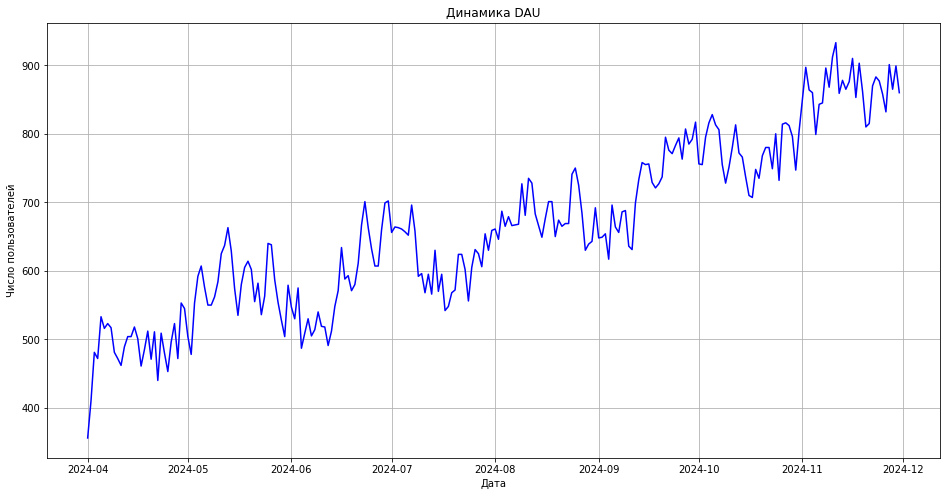

In [22]:
#Задача 1
#Рассчитаем DAU
dau = df_visits.groupby('session_start')['user_id'].nunique().reset_index()
plt.figure(figsize = (16,8))
plt.plot(dau['session_start'], dau['user_id'], color = 'blue')
plt.title('Динамика DAU')
plt.xlabel('Дата')
plt.ylabel('Число пользователей')
plt.grid()
plt.show()

Рост DAU означает, что всё больше людей используют продукт каждый день. Увелчиивается активная аудитория, что может быть вызвано большим потоком новых пользователей с рекламных кампаний. 

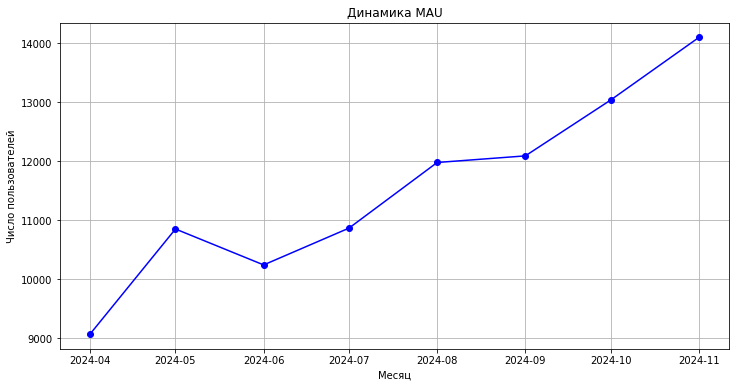

In [23]:
#Рассчитаем MAU
mau = df_visits.copy()
mau['session_start'] = mau['session_start'].dt.to_period('M').dt.to_timestamp()
mau = mau.groupby('session_start')['user_id'].nunique().reset_index().rename(columns = {'session_start':'month'})
plt.figure(figsize = (12,6))
plt.plot(mau['month'], mau['user_id'], marker = 'o', color = 'blue')
plt.title('Динамика MAU')
plt.xlabel('Месяц')
plt.ylabel('Число пользователей')
plt.grid()
plt.show()

Рост MAU показывает, что продукт привлекает больше уникальной аудитории в течение месяца. Это означает, что увеличивается общий охват сервиса: приходят новые пользователи или возвращаются те, кто давно не заходил. В совокупности с ростом DAU это хороший сценарий, так как пользователи не просто приходят, но и задерживаются в продукте. 

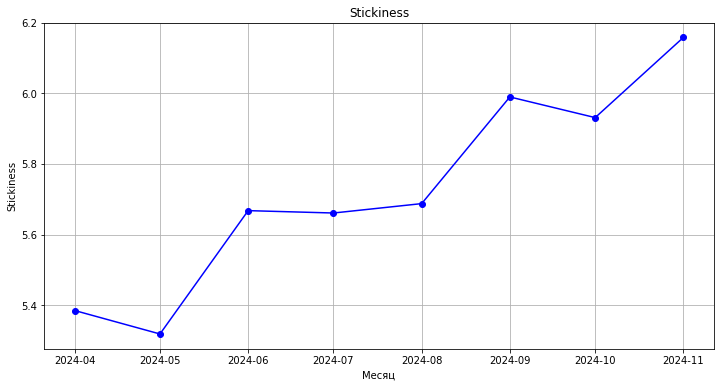

In [24]:
# Рассчитаем Stickiness
#Считаем среднемесячное DAU
dau['month'] = dau['session_start'].dt.to_period('M').dt.to_timestamp()
dau_monthly_average = dau.groupby('month')['user_id'].mean().reset_index()
#Объединяем с датафреймом MAU
stickiness_table = pd.merge(dau_monthly_average, mau, on = 'month', how = 'left')
#Считаем stickiness
stickiness_table['stick'] = 100 * (stickiness_table['user_id_x'] / stickiness_table['user_id_y'])
#Строим график для метрики
plt.figure(figsize = (12,6))
plt.plot(stickiness_table['month'], stickiness_table['stick'], marker = 'o', color = 'blue')
plt.title('Stickiness')
plt.xlabel('Месяц')
plt.ylabel('Stickiness')
plt.grid()
plt.show()

Повышение MAU, DAU и Stickiness означает рост вовлечённости и популярности продукта. MAU растет (месячные активные пользователи), это говорит о том, что увеличивается общая аудитория — либо за счёт новых пользователей, либо благодаря возвращению старых. Рост DAU (дневные активные пользователи) показывает, что люди пользуются продуктом чаще, заходят ежедневно. Stickiness (липкость), которая рассчитывается как отношение DAU к MAU, отражает, насколько часто пользователи возвращаются в продукт. В продукте этот показатель растёт, а значит, он становится частью привычек пользователей — они используют его регулярно, а не от случая к случаю. Это очень хороший сценарий развития. 

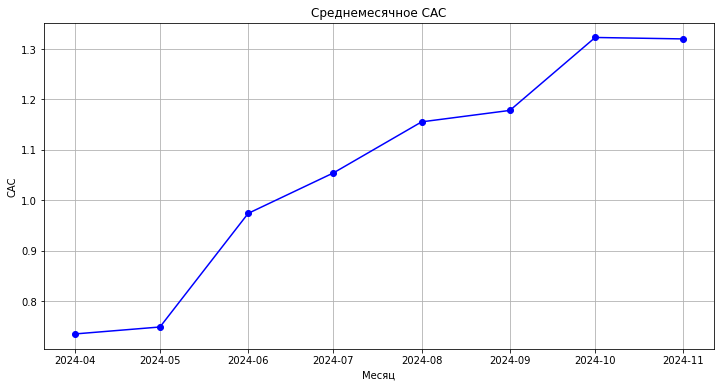

In [25]:
#Задание 2
# Рассчитаем среднемесячное значение CAC
cac = profiles.copy()
cac['first_month'] = pd.to_datetime(profiles['first_dt']).dt.to_period('M').dt.to_timestamp()
cac = cac.groupby('first_month')['cac'].mean().reset_index()
#Рисуем график
plt.figure(figsize = (12,6))
plt.plot(cac['first_month'], cac['cac'], marker = 'o', color = 'blue')
plt.title('Среднемесячное CAC')
plt.xlabel('Месяц')
plt.ylabel('CAC')
plt.grid()
plt.show()

Рост среднемесячного CAC говорит о том, что бизнес тратит больше денег на привлечение каждого нового пользователя. Это может быть вызвано снижением эффективности использования рекламных каналов. Такой резкий скачок указывает на необходимость пересмотра рекламных каналов и улучшения таргетинга новых пользователей. Но чтобы лучше оценить ситуацию, перейдем к расчету LTV и ROI с учётом покупок, совершённых за 28 дней с момента привлечения. Так мы поймем, окупаются ли вложения на привлечения пользователей. 

Так как при расчете ROI нам потребуются в том числе пользователи, не совершавшие покупки, нам будет необходимо обращаться к двум датафреймам - df_orders и df_visits.

In [26]:
#Создаем столбец с месяцом привлечения пользователя
df_visits['first_month'] = pd.to_datetime(df_visits['first_dt']).dt.to_period('M').dt.to_timestamp()
df_orders['first_month'] = pd.to_datetime(df_orders['first_dt']).dt.to_period('M').dt.to_timestamp()
df_costs['first_month'] = pd.to_datetime(df_costs['dt']).dt.to_period('M').dt.to_timestamp()

In [27]:
# Фильтруем заказы, сделанные в первые 28 дней после привлечения
df_orders_28 = df_orders[(df_orders['lifetime'] < 28) & (df_orders['first_month'] < '2024-11-01')]
# Рассчитываем LTV по месяцам привлечения
ltv_month = df_orders_28.groupby('first_month')['revenue'].sum().reset_index().rename(columns={'revenue': 'total_revenue'})
# Рассчитываем количество пользователей по месяцам привлечения
users_month = df_visits[df_visits['first_month'] < '2024-11-01'].groupby('first_month')['user_id'].nunique().reset_index().rename(columns={'user_id': 'total_users'})
# Рассчитываем CAC по месяцам привлечения
cac_month = df_costs[df_costs['first_month'] < '2024-11-01'].groupby('first_month')['costs'].sum().reset_index().rename(columns={'costs': 'total_cac'})
#Объединяем данные для дальнейших расчетов
monthly_metrics = pd.merge(users_month, ltv_month, on='first_month', how='left')
monthly_metrics = pd.merge(monthly_metrics, cac_month, on='first_month', how='left')
#Считаем метрики
monthly_metrics['LTV'] = monthly_metrics['total_revenue'] / monthly_metrics['total_users']
monthly_metrics['CAC'] = monthly_metrics['total_cac'] / monthly_metrics['total_users']
monthly_metrics['ROI'] = ((monthly_metrics['LTV'] - monthly_metrics['CAC']) / monthly_metrics['CAC']) * 100
monthly_metrics

,first_month,total_users,total_revenue,total_cac,LTV,CAC,ROI
0,2024-04-01,9069,7425.629883,6663.052246,0.818793,0.734706,11.444870
1,2024-05-01,9789,8141.759766,7327.775391,0.831725,0.748572,11.108206
2,2024-06-01,8719,7447.839844,8492.117188,0.854208,0.973978,-12.297020
3,2024-07-01,8742,9991.410156,9217.078125,1.142920,1.054344,8.401057
4,2024-08-01,9518,10367.049805,10999.013672,1.089205,1.155601,-5.745641
5,2024-09-01,9198,10085.879883,10838.014648,1.096530,1.178301,-6.939784
6,2024-10-01,9520,11449.709961,12595.403320,1.202701,1.323047,-9.096123


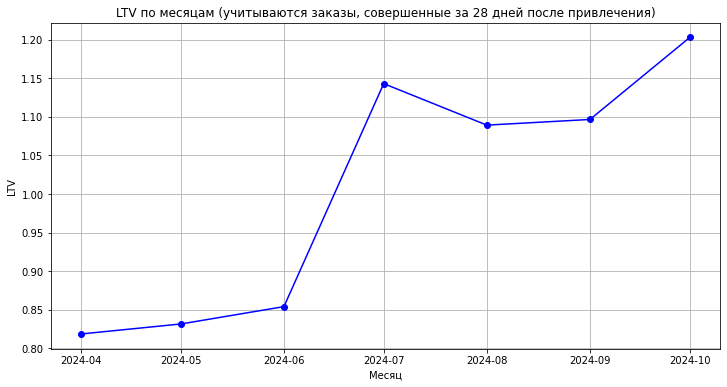

In [28]:
#Визуализируем изменение метрик 
plt.figure(figsize = (12,6))
plt.plot(monthly_metrics['first_month'], monthly_metrics['LTV'], marker = 'o', color = 'blue')
plt.title('LTV по месяцам (учитываются заказы, совершенные за 28 дней после привлечения)')
plt.xlabel('Месяц')
plt.ylabel('LTV')
plt.grid()
plt.show()

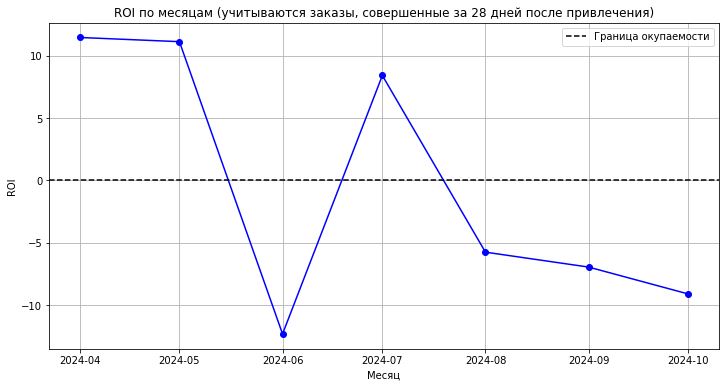

In [29]:
#Визуализируем изменение метрик 
plt.figure(figsize = (12,6))
plt.plot(monthly_metrics['first_month'], monthly_metrics['ROI'], marker = 'o', color = 'blue')
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')
plt.title('ROI по месяцам (учитываются заказы, совершенные за 28 дней после привлечения)')
plt.xlabel('Месяц')
plt.ylabel('ROI')
plt.legend()
plt.grid()
plt.show()

### Промежуточный вывод
Показатели таких метрик как DAU, MAU, Stickiness стабильно растут на протяжении исследуемого периода в том числе и летом, после введения спортивного контента. 

Среднемесячное СAC имеет четкий тренд на рост: к 2024-11 он вырос более чем в два раза с 2024-06. Причиной этому могут быть: увеличение общих затрат на маркетинг, стоимости привлечения по каналам или уменьшения количества привлченных пользователей. Среднемесячное LTV показывает резкий скачок в начале лета, совпадающий с запуском нового контента, после чего стабилизируется в новых значениях.

После введения нового контента ROI оказывается выше уровня окупаемости лишь в июле. Учитывая рост и LTV, и СAC, можно предположить что затраты на привлечение клиента не окупаются. 

## Анализ метрик в разрезе источника привлечения

Теперь необходимо разобраться, какие источники привлечения перспективны, а какие за 28 дней не окупились.

In [30]:
#Задача 1 
#Считаем общее число привлеченных пользователей по источникам
users_per_channel = profiles.groupby('first_channel')['user_id'].nunique().reset_index().sort_values('user_id', ascending = False).rename(columns = {'user_id':'total_users'})
users_per_channel

,first_channel,total_users
0,FaceBoom,28401
3,TipTop,18118
2,RocketSuperAds,14257
1,MediaTornado,14080


Лидером среди источников привлечения новых пользователей является FaceBoom, через него пришло 28 401 пользователь. Менее популярен канал TipTop - 18 118 человек. RocketSuperAds и MediaTornado привлекли примерно одинаковое число клиентов - 14 257 и 14 080  соответственно. 

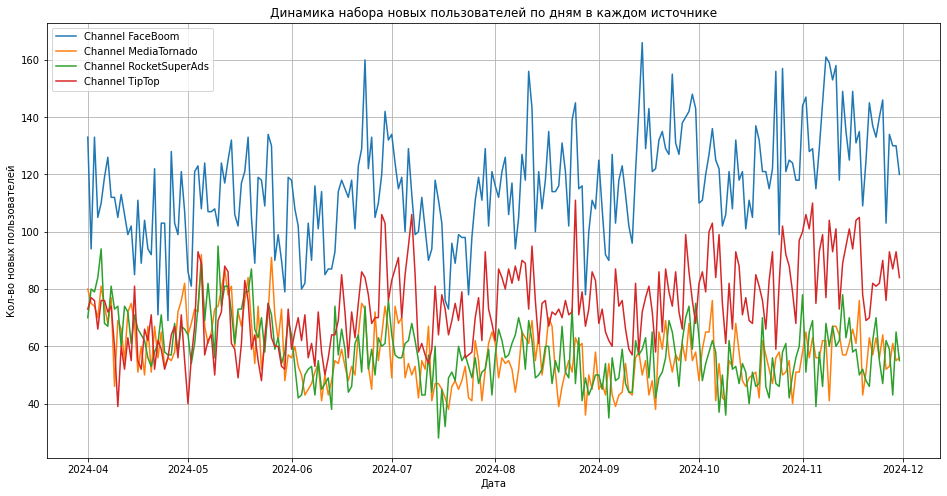

In [31]:
#Визуализируем динамику набора новых пользователей по дням в каждом источнике
users_per_channel_day = profiles.groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index()
plt.figure(figsize = (16,8))
for channel in users_per_channel_day['first_channel'].unique():
    df_plot = users_per_channel_day[users_per_channel_day['first_channel'] == channel]
    plt.plot(df_plot['first_dt'], df_plot['user_id'], label = f'Channel {channel}')
    
    
plt.title('Динамика набора новых пользователей по дням в каждом источнике')
plt.xlabel('Дата')
plt.ylabel('Кол-во новых пользователей')
plt.grid()
plt.legend()
plt.show()

На графике видно, что наибольшее число пользователей каждый день привлекает канал FaceBoom. В начале лета, с введением спортивного контента, TipTop начал увеличивать количество привлеченных, в то время как MediaTornado и RocketSuperAds немного сократили. Это может быть связано как с ухудшением эффективности этих каналов, так и с сокращением их маркетингового финансирования. 

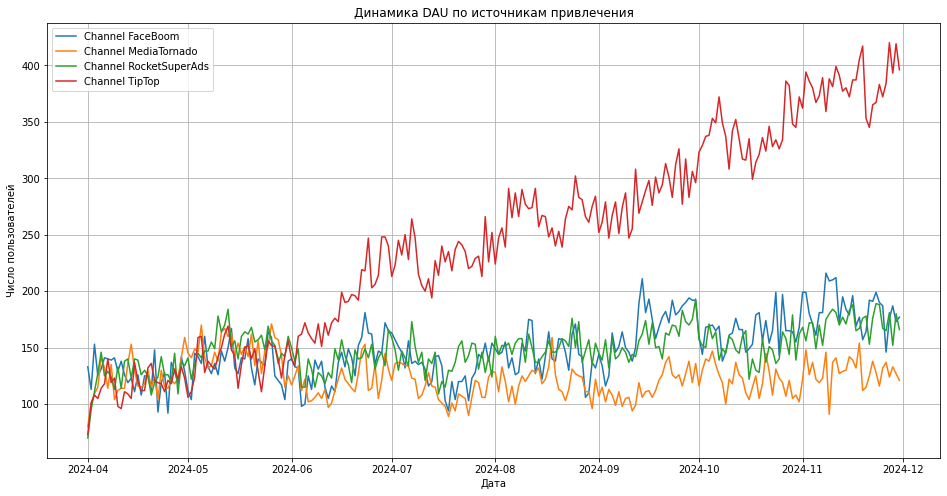

In [32]:
#Рассчитываем и визуализируем динамику DAU, MAU и Stickiness по источникам привлечения
dau_channel = df_visits.groupby(['session_start', 'first_channel'])['user_id'].nunique().reset_index()
plt.figure(figsize = (16,8))
for channel in dau_channel['first_channel'].unique():
    df_plot = dau_channel[dau_channel['first_channel'] == channel]
    plt.plot(df_plot['session_start'], df_plot['user_id'], label = f'Channel {channel}')

plt.title('Динамика DAU по источникам привлечения')
plt.xlabel('Дата')
plt.ylabel('Число пользователей')
plt.grid()
plt.legend()
plt.show()

С начала лета наметился тренд на резкий рост DAU канала TipTop, что означает высокую заинтересованность этой аудитории в продукте. RocketSuperAds и FaceBoom имеют стабильную динамику на протяжении всего рассматриваемого периода. 

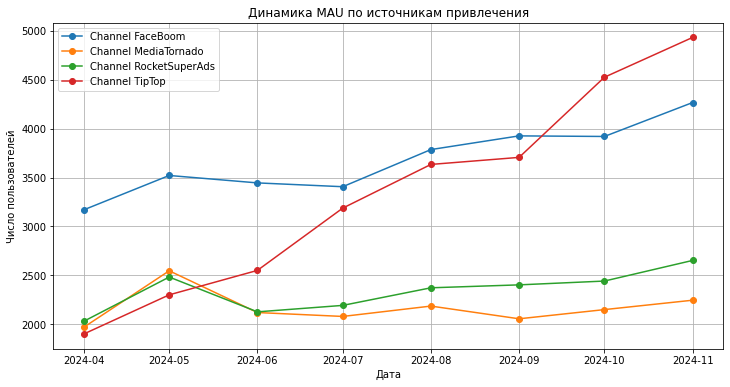

In [33]:
mau_channel = df_visits.copy()
mau_channel['month'] = pd.to_datetime(df_visits['session_start']).dt.to_period('M').dt.to_timestamp()
mau_channel = mau_channel.groupby(['month', 'first_channel'])['user_id'].nunique().reset_index()
plt.figure(figsize = (12,6))
for channel in mau_channel['first_channel'].unique():
    df_plot = mau_channel[mau_channel['first_channel'] == channel]
    plt.plot(df_plot['month'], df_plot['user_id'], label = f'Channel {channel}', marker = 'o')

plt.title('Динамика MAU по источникам привлечения')
plt.xlabel('Дата')
plt.ylabel('Число пользователей')
plt.grid()
plt.legend()
plt.show()

MAU пользователей, привлеченных из TipTop, имеет четкий тренд на рост, что в сочетании с ростом MAU свидетельствует о высокой вовлеченности аудитории в продукт. MAU канала FaceBoom тоже находится на высоком уровне, однако вместе с показателями MAU говорят о низком Stickiness. 

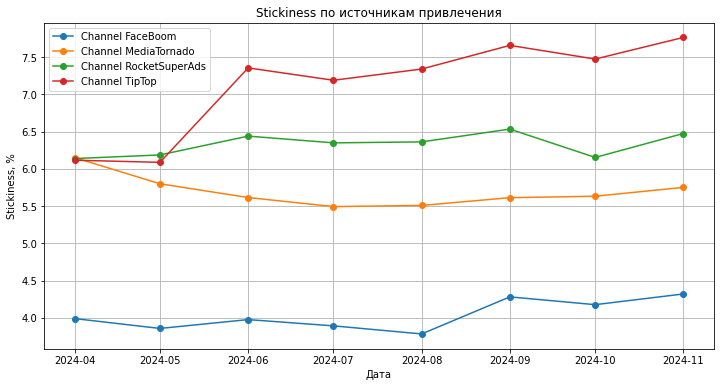

In [34]:
dau_channel['month'] = pd.to_datetime(dau_channel['session_start']).dt.to_period('M').dt.to_timestamp()
dau_channel_monthly = dau_channel.groupby(['month', 'first_channel'])['user_id'].mean().reset_index().rename(columns = {'user_id':'dau_month'})
stickiness_table = pd.merge(mau_channel, dau_channel_monthly, on = ['month', 'first_channel'], how = 'left')
stickiness_table['stick'] = (stickiness_table['dau_month'] / stickiness_table['user_id']) * 100

plt.figure(figsize = (12,6))
for channel in stickiness_table['first_channel'].unique():
    df_plot = stickiness_table[stickiness_table['first_channel'] == channel]
    plt.plot(df_plot['month'], df_plot['stick'], label = f'Channel {channel}', marker = 'o')

plt.title('Stickiness по источникам привлечения')
plt.xlabel('Дата')
plt.ylabel('Stickiness, %')
plt.grid()
plt.legend()
plt.show()

Видим, что наиболее высокий коэффициент залипания имеет аудитория, привлеченная из канала TipTop, несмотря на то, что пользователей меньше, чем у FaceBoom. Это свидетельствует о сильной вовлеченности в контент продукта и заинтересованности. Канал FaceBoom, хотя и привлекает замый большой трафик, имеет низкий коэффициент Stickiness. Это значит, что пользователи менее вовлечены и стоит задуматься над успешностью таргетирования через него. 

Достаточно стабильный Stickiness имеет канал RocketSuperAds. Хотя он привлекает небольшой трафик, но пользователи увлеченные и заинтересованные. Чуть менее вовлечены пользователи из TornadoBoom.

Перейдем к анализу метрик в разрезе источника привлечения и когорт, выделенных по неделе привлечения. Для начала добавим в датафреймы столбец с когортой. 

In [35]:
#Добавляем недельную когорту
profiles['week_cohort'] = pd.to_datetime(profiles['first_dt']).dt.to_period('W').dt.to_timestamp()
df_visits['week_cohort'] = pd.to_datetime(df_visits['first_dt']).dt.to_period('W').dt.to_timestamp()
df_orders['week_cohort'] = pd.to_datetime(df_orders['first_dt']).dt.to_period('W').dt.to_timestamp()
#у первой когорты ноября лайфтайм составляет 26 дней, что делает данные неполными, поэтому отфильтровываем когорты этого месяца
df_orders_28 = df_orders[(df_orders['lifetime'] < 28) & (df_orders['week_cohort'] < '2024-11-01')]
df_visits_28 = df_visits[(df_visits['lifetime'] < 28) & (df_visits['week_cohort'] < '2024-11-01')]

users_per_cohort_channel = profiles[profiles['week_cohort'] < '2024-11-01'].groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index().rename(
    columns = {'user_id':'cohort_size'})
#Оставляем только сессии с лайфтайм 14-28
retained_users_per_cohort_channel = df_visits_28[(df_visits_28['lifetime'] > 13) & (df_visits_28['week_cohort'] < '2024-11-01')].groupby(
    ['week_cohort', 'first_channel'])['user_id'].nunique().reset_index().rename(columns ={'user_id':'retained_users'}).fillna(0)

retention_by_cohort_channel = pd.merge(users_per_cohort_channel, retained_users_per_cohort_channel, 
                                       on = ['week_cohort', 'first_channel'], how = 'left').fillna(0)

retention_by_cohort_channel['retention_rate']=retention_by_cohort_channel['retained_users']/retention_by_cohort_channel['cohort_size']
retention_by_cohort_channel.head()

,week_cohort,first_channel,cohort_size,retained_users,retention_rate
0,2024-04-01,FaceBoom,820,10,0.012195
1,2024-04-01,MediaTornado,522,48,0.091954
2,2024-04-01,RocketSuperAds,542,67,0.123616
3,2024-04-01,TipTop,516,66,0.127907
4,2024-04-08,FaceBoom,749,10,0.013351


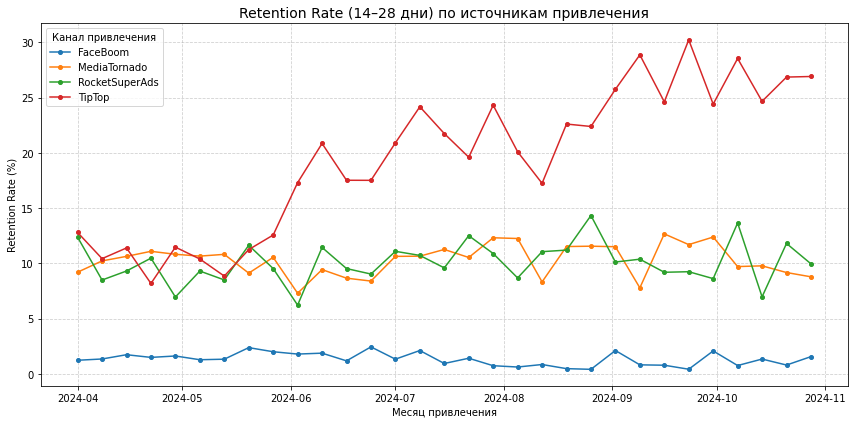

In [36]:
# Дата последнего визита
last_session_date = df_visits_28[df_visits_28['lifetime'] > 13]['session_start'].max().date()

# Фильтруем когорты
complete_cohorts = retention_by_cohort_channel[
    (retention_by_cohort_channel['week_cohort'].dt.date + pd.Timedelta(days=28)) <= last_session_date
]

plt.figure(figsize=(12, 6))

for channel in complete_cohorts['first_channel'].unique():
    df = complete_cohorts[complete_cohorts['first_channel'] == channel]
    plt.plot(df['week_cohort'], df['retention_rate'] * 100, label=channel, marker='o', markersize=4)

plt.title('Retention Rate (14–28 дни) по источникам привлечения', fontsize=14)
plt.xlabel('Месяц привлечения')
plt.ylabel('Retention Rate (%)')
plt.legend(title='Канал привлечения')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Высокая вовлеченность пользователей, привлеченных из канала TipTop, подтверждается высоким Retention rate на 14-28 дни. Стабильный показатель, колеблющийся в районе 7-12% имеют RocketSuperAds и TornadoBoom. Низкое удержание показывает FaceBoom (менее 5%), пользователи холодны к продукту. 

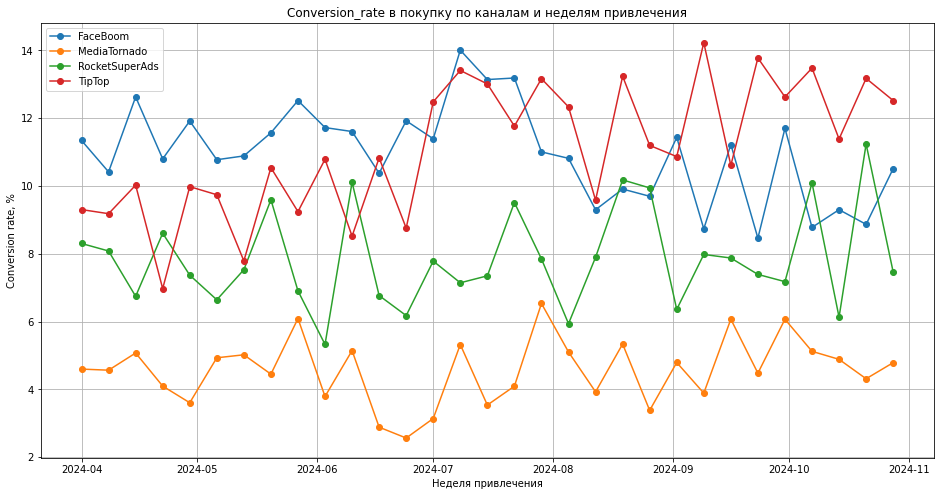

In [37]:
# Считаем конверсию в покупку
orders_per_cohort = df_orders_28.groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index().rename(columns = {'user_id':'orders'})
users_per_cohort = df_visits_28.groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index()

conversion = pd.merge(users_per_cohort, orders_per_cohort, on = ['week_cohort', 'first_channel'], how = 'left')
conversion['CR'] = (conversion['orders'] / conversion['user_id']) * 100
plt.figure(figsize = (16,8))
for channel in conversion['first_channel'].unique():
    df_plot = conversion[conversion['first_channel'] == channel]
    plt.plot(df_plot['week_cohort'], df_plot['CR'], marker = 'o', label = f'{channel}')
    
plt.title('Conversion_rate в покупку по каналам и неделям привлечения')
plt.xlabel('Неделя привлечения')
plt.ylabel('Conversion rate, %')
plt.grid()
plt.legend()
plt.show()

Несмотря на то, что конверсия канала FaceBoom одна из лучших, этот источник трафика имеет низкие показатели вовлеченности, а значит пользователи из него склонны к разовым и импульсивным покупкам. 

TipTop демонстрирует хороший уровень конверсии. С учетом того, что пользователи заинтересованы в продукте, в перспективе они могут стать стабильным источником дохода компании.

RocketSuperAds имеет более низкую конверсию (от 5 до 11%), что неплохо. Менее склонные к покупкам пользователи привлечены из MediaTornado.

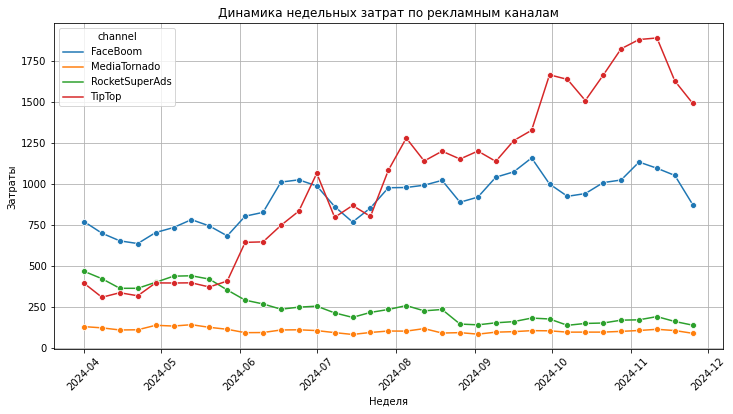

In [38]:
#Динамика недельных затрат по каждому источнику привлечения
df_costs['week'] = pd.to_datetime(df_costs['dt']).dt.to_period('W').dt.to_timestamp()
marketing_costs_per_week = df_costs.groupby(['week', 'channel'])['costs'].sum().reset_index()

# Визуализация
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=marketing_costs_per_week,
    x='week',
    y='costs',
    hue='channel',
    marker='o'
)
plt.title('Динамика недельных затрат по рекламным каналам')
plt.xlabel('Неделя')
plt.ylabel('Затраты')
plt.xticks(rotation=45)
plt.grid()
plt.show()

В июне компания направила большую часть маркетинговых затрат в каналы TipTop и FaceBoom, сократив финансирование RocketSuperAds. Это объясняет более высокий трафик новых пользователей из этих каналов. Необходимо узнать, окупаются ли эти сложения. 

In [39]:
# Группируем данные по неделям и каналам
weekly_metrics = profiles[profiles['week_cohort'] < '2024-11-01'].groupby(['week_cohort', 'first_channel']).agg(cohort_size=('user_id', 'count'), 
                                                                        total_cac=('cac', 'sum')).reset_index()

# Выручка по недельным когортам
revenue_by_cohort = df_orders_28.groupby(['week_cohort', 'first_channel'])['revenue'].sum().reset_index().rename(columns={'revenue': 'total_revenue'})


# Объединяем вместе
weekly_metrics = pd.merge(weekly_metrics, revenue_by_cohort, on=['week_cohort', 'first_channel'], how='left')
weekly_metrics = weekly_metrics.fillna({'total_revenue': 0})

# Считаем LTV, CAC и ROI
weekly_metrics['ltv'] = weekly_metrics['total_revenue'] / weekly_metrics['cohort_size']
weekly_metrics['cac'] = weekly_metrics['total_cac'] / weekly_metrics['cohort_size']
weekly_metrics['roi'] = ((weekly_metrics['ltv'] - weekly_metrics['cac']) / weekly_metrics['cac']) * 100

weekly_metrics.head()

,week_cohort,first_channel,cohort_size,total_cac,total_revenue,ltv,cac,roi
0,2024-04-01,FaceBoom,820,769.875908,380.359985,0.463854,0.938873,-50.594637
1,2024-04-01,MediaTornado,522,129.318321,191.429993,0.366724,0.247736,48.030063
2,2024-04-01,RocketSuperAds,542,466.649994,724.330017,1.336402,0.860978,55.219121
3,2024-04-01,TipTop,516,393.989384,795.399963,1.541473,0.763545,101.883603
4,2024-04-08,FaceBoom,749,698.872742,337.059998,0.450013,0.933074,-51.770905


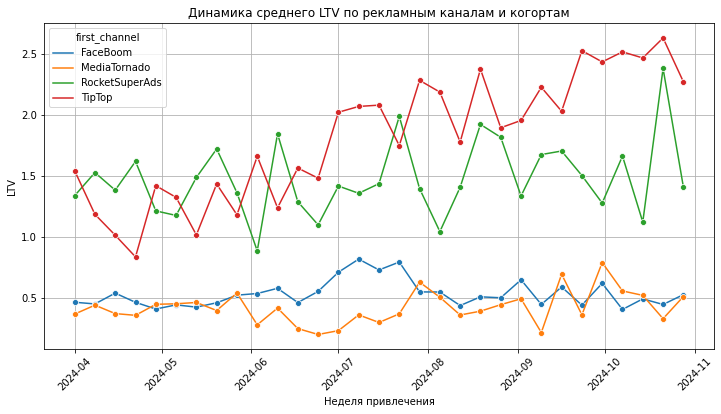

In [40]:
#Динамика ltv
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=weekly_metrics,
    x='week_cohort',
    y='ltv',
    hue='first_channel',
    marker='o'
)
plt.title('Динамика среднего LTV по рекламным каналам и когортам')
plt.xlabel('Неделя привлечения')
plt.ylabel('LTV')
plt.xticks(rotation=45)
plt.grid()
plt.show()

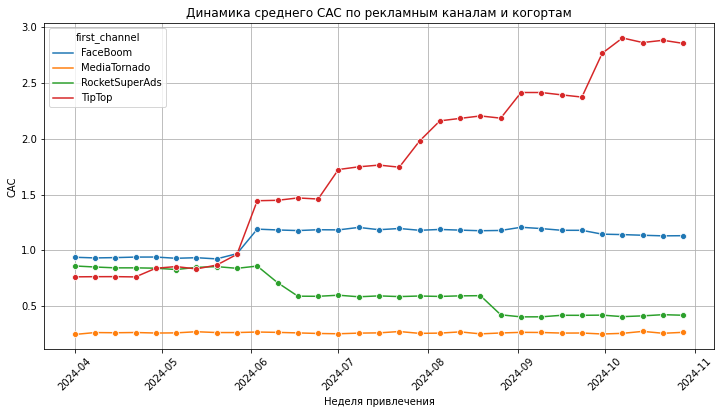

In [41]:
#Динамика cac
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=weekly_metrics,
    x='week_cohort',
    y='cac',
    hue='first_channel',
    marker='o'
)
plt.title('Динамика среднего CAC по рекламным каналам и когортам')
plt.xlabel('Неделя привлечения')
plt.ylabel('CAC')
plt.xticks(rotation=45)
plt.grid()
plt.show()

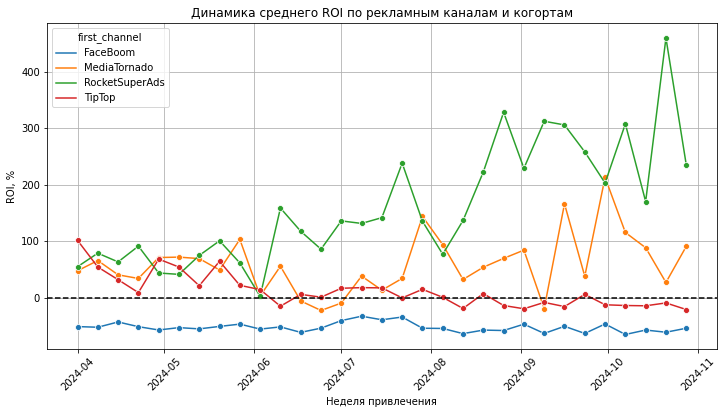

In [42]:
#Динамика среднего roi
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=weekly_metrics,
    x='week_cohort',
    y='roi',
    hue='first_channel',
    marker='o'
)
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')
plt.title('Динамика среднего ROI по рекламным каналам и когортам')
plt.xlabel('Неделя привлечения')
plt.ylabel('ROI, %')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Наиболее окупающийся канал RocketSuperAds. Он имеет низкий CAC, но высокий LTV. 

Несмотря на самый высокий LTV канал TipTop не окупается за 4 недели, что не соответствует стратегии компании. 

FaceBoom показывает самые низкие показатели окупаемости, что говорит о нецелесообразности больших вложений в него. 

Окупаемость MediaTornado нестабильна.

### Промежуточный вывод
**FaceBoom:** канал, обеспечивающий наибольший трафик новых пользователей, однако коэффициент Stickiness ниже, чем у остальных источников. Это говорит о том, что канал привлекает пользователей, не вовлекающихся в продукт, что подтверждается динамикой Retention rate на период 14-28 дней после первого контакта: он стабильно низок (1-3%) для всех когорт, выделенных по месяцу привлечения. Хотя эти пользователи показывают один из самых высоких коэффициентов конверсии в покупку, их средний LTV низок и не покрывает CAC, поэтому маркетинговые вложения не окупаются на протяжении всего периода. Можно предположить, что из этого источника приходят клиенты, которым продукт нужен разово и не подходит в долгосрочной перспективе, или же это импульсивные клиенты. Не стоит инвестировать в этот источник. 

**Tiptop:** так же как и FaceBoom привлекает большое число новых клиентов, в том числе и после введения спортивного контента. Это связано с увеличением суммарных маркетинговых затрат на этот источник в июне. Он показывает самые высокие результаты по Stickiness. После введения спортивного контента резко возрос Retention rate (14-28 день), что говорит от вовлеченности пользователей, так же возросла и конверсия в покупку и среднее LTV пользователей, привлеченных после нововведений. Вместе с этим вырос и CAC, а ROI не достигает границы окупаемости. Аудитория вовлеченная в спортивный контент, но канал не окупается. Стоит попытаться увеличить доход с клиента, или снизить стоимость привлечения, либо сократить инвестиции в этот канал при неудачных тестах. 

**RocketSuperAds:** показывает стабильный, но небольшой (оправдывается низкими маркетинговыми затратами) в сравнении с предыдущими каналами, трафик на протяжении всего исследуемого периода. Аудитория вовлеченная и заинтересованная, готова совершать покупки. После введения спортивного контента ROI резко возросло, так как снизился CAC. это стабильный, низкобюджетный канал, который привлекает вовлечённую и платежеспособную аудиторию. Стоит его масштабировать. 

**MediaTornado:** привлекает такое же количество новых пользователей, как и RocketSuperAds. Показатели Stickiness и Retention rate схожи с этим каналом. Аудитория менее склонна к покупкам и тратит меньшие суммы, но LTV покрывает CAC, что позволяет затратам на маркетинг в большинстве когорт окупиться, однако не всегда. 

## Анализ периода окупаемости маркетинговых вложений

Для источников, которые к 28-му дню не выходят на уровень окупаемости, рассчитаем и визуализируем в виде тепловой карты значения ROI за больший период, например за 8–10 недель.

Разделим данные на недельные когорты по дате привлечения, в качестве интервала наблюдений используем недели.

In [43]:
#Выделяем неделю заказа и неделю привлечения
df_orders['order_week'] = df_orders['event_dt'].dt.to_period('W').dt.to_timestamp()
df_orders['first_week'] = df_orders['first_dt'].dt.to_period('W').dt.to_timestamp()

df_orders['N_week'] = (df_orders['order_week'] - df_orders['first_week']).dt.days / 7
users_count = profiles.groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index()

first_week_cac = profiles.groupby(['week_cohort', 'first_channel'])['cac'].sum().reset_index().rename(
    columns={'cac': 'total_cac'})

# рассчитаем кумулятивную выручку
revenue_cumulative = df_orders[df_orders['N_week'] < 8].groupby(['week_cohort', 'N_week', 'first_channel'])['revenue'].sum().groupby(['week_cohort', 'first_channel']).cumsum().reset_index().rename(
    columns={'revenue': 'cumulative_revenue'})

metrics = pd.merge(first_week_cac, revenue_cumulative, on = ['week_cohort', 'first_channel'], how = 'left')
metrics = pd.merge(metrics, users_count, on = ['week_cohort', 'first_channel'], how = 'left')

# Расчет метрик
metrics['cac'] = metrics['total_cac'] / metrics['user_id']
metrics['ltv'] = metrics['cumulative_revenue'] / metrics['user_id']
metrics['roi'] = (metrics['ltv'] - metrics['cac']) / metrics['cac']

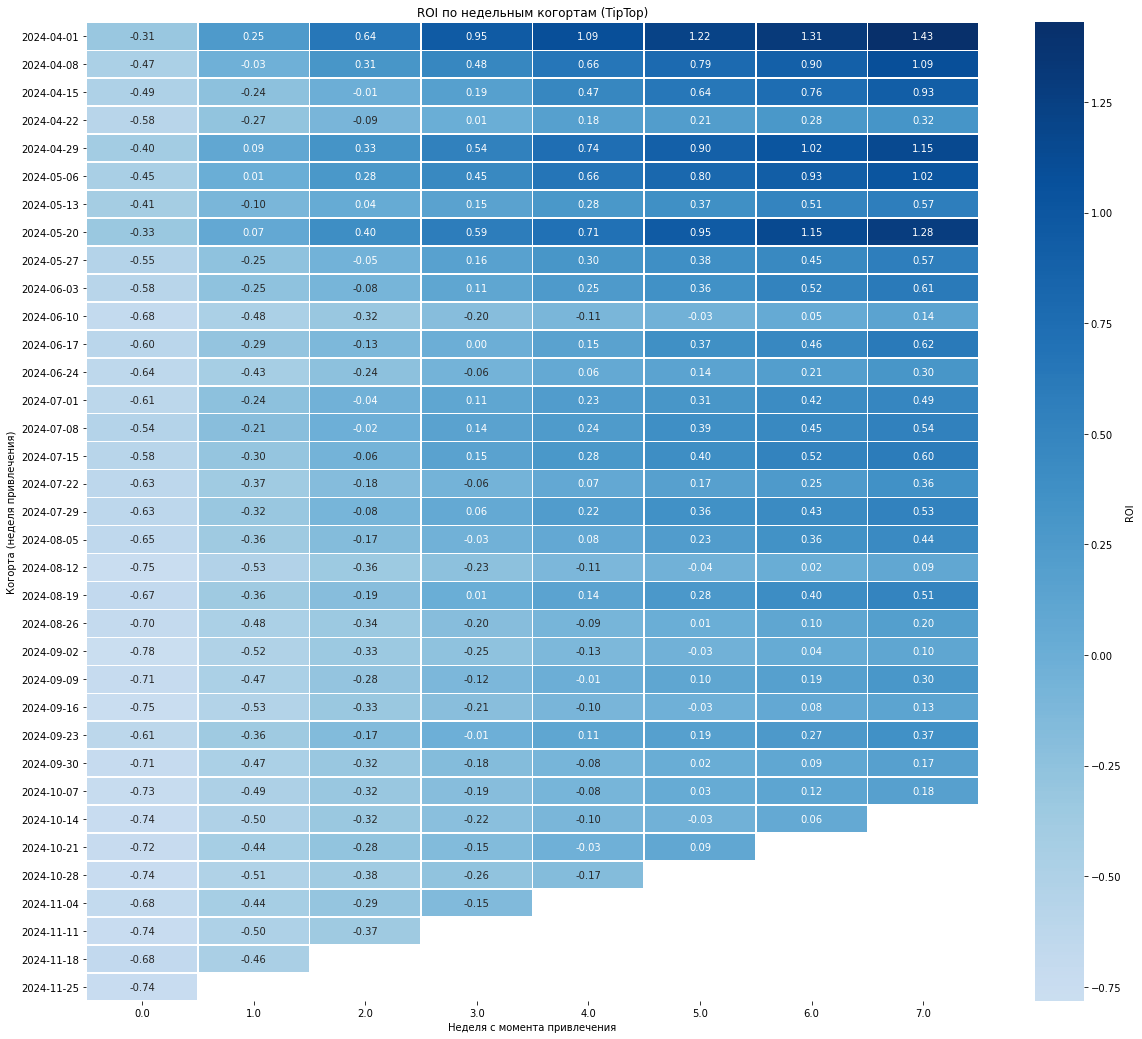

In [44]:
# Визуализируем
metrics['week_cohort'] = metrics['week_cohort'].dt.strftime('%Y-%m-%d')

plt.figure(figsize=(20, 18))
heatmap_data = metrics[metrics['first_channel'] == 'TipTop'].pivot(
    index='week_cohort',
    columns='N_week',
    values='roi'
)
cmap = 'Blues'
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'ROI'}
)
plt.title('ROI по недельным когортам (TipTop)')
plt.xlabel('Неделя с момента привлечения')
plt.ylabel('Когорта (неделя привлечения)')
plt.show()

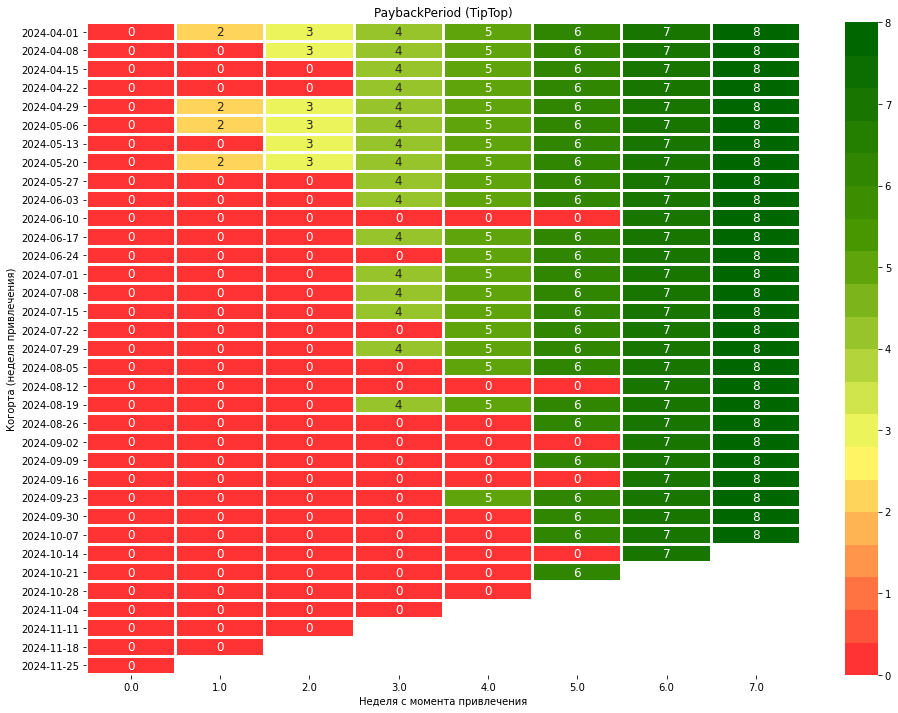

In [45]:
#Визуализируем Payback Period
payback = metrics[metrics['first_channel'] == 'TipTop'][['week_cohort', 'N_week', 'cac', 'ltv']].copy()

# Рассчитаем Payback Period
payback['Payback_Period'] = payback.apply(
    lambda row: row['N_week'] + 1 if row['ltv'] >= row['cac'] else 0, axis=1)

df_pivot = payback.pivot(index = 'week_cohort', 
                                     columns = 'N_week',
                                     values = 'Payback_Period')



cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900', '#006600'], N=20)

plt.figure(figsize=(16, 12))

sns.heatmap(df_pivot,
          cmap=cmap,
          annot=True,
          fmt='.0f',
          linewidths=2,
          annot_kws={"size": 12})


plt.title('PaybackPeriod (TipTop)')
plt.xlabel('Неделя с момента привлечения')
plt.ylabel('Когорта (неделя привлечения)')
plt.show()

**Вывод по анализу окупаемости канала TipTop:** половина когорт из этого источника, выделенных по неделе привлечения, начинают окупаться, то есть ROI > 0, на 4 неделе после привлечения. Все когорты достигают Payback Period на 7 неделе после привлечения. TipTop — надежный канал, и бизнесу можно попробовать ускорить окупаемость и увеличить прибыль.



Посмотрим на ROI и период окупаемости канала FaceBoom.

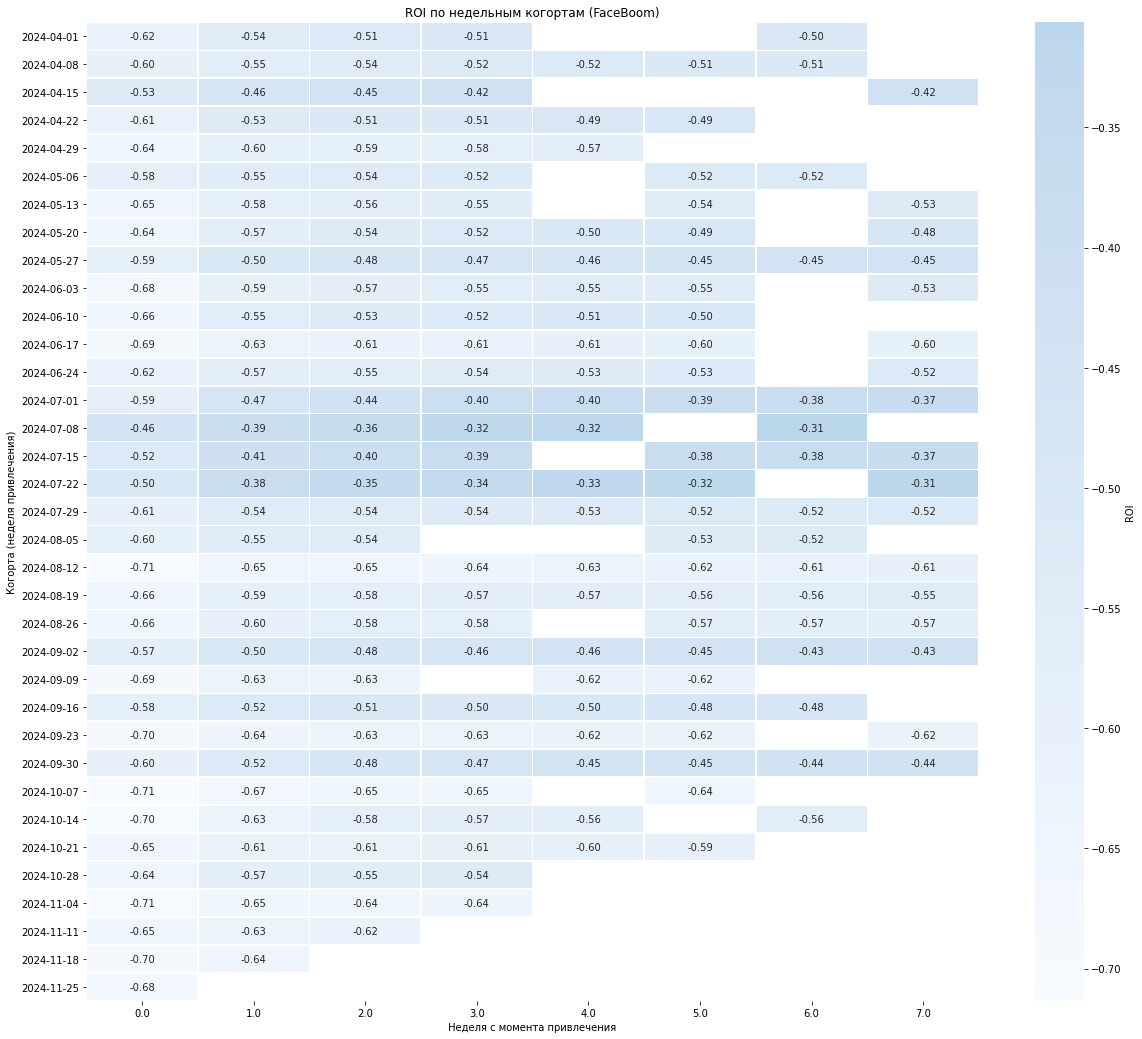

In [46]:
# Визуализируем
plt.figure(figsize=(20, 18))
heatmap_data = metrics[metrics['first_channel'] == 'FaceBoom'].pivot(
    index='week_cohort',
    columns='N_week',
    values='roi'
)
cmap = 'Blues'
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'ROI'}
)
plt.title('ROI по недельным когортам (FaceBoom)')
plt.xlabel('Неделя с момента привлечения')
plt.ylabel('Когорта (неделя привлечения)')
plt.show()

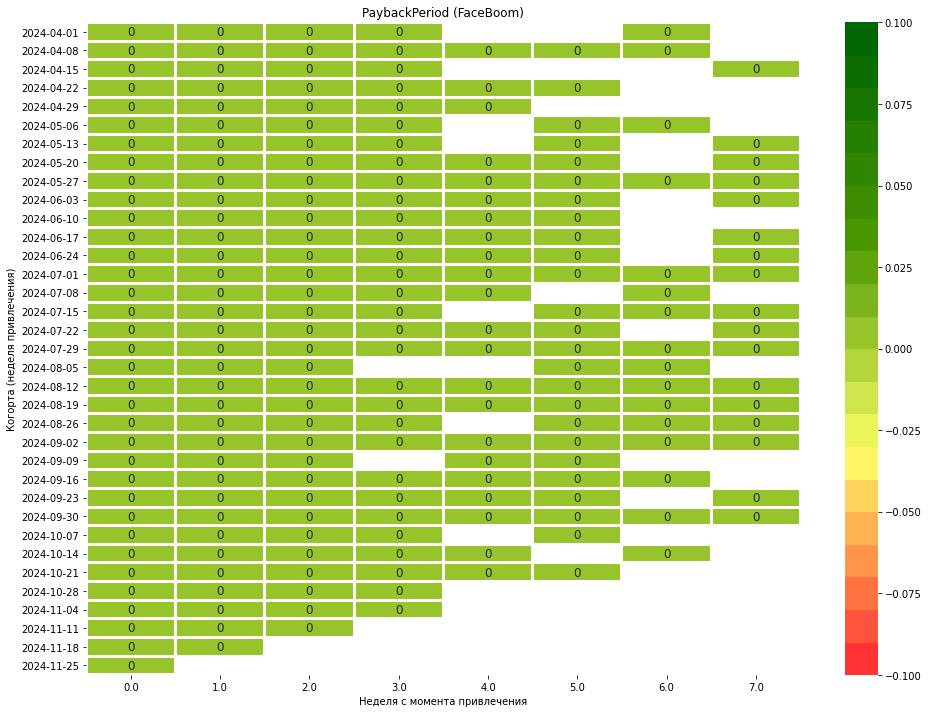

In [47]:
#Визуализируем Payback Period
payback = metrics[metrics['first_channel'] == 'FaceBoom'][['week_cohort', 'N_week', 'cac', 'ltv']].copy()

# Рассчитаем Payback Period
payback['Payback_Period'] = payback.apply(
    lambda row: row['N_week'] + 1 if row['ltv'] >= row['cac'] else 0, axis=1)

df_pivot = payback.pivot(index = 'week_cohort', 
                                     columns = 'N_week',
                                     values = 'Payback_Period')



cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900', '#006600'], N=20)

plt.figure(figsize=(16, 12))

sns.heatmap(df_pivot,
          cmap=cmap,
          annot=True,
          fmt='.0f',
          linewidths=2,
          annot_kws={"size": 12})


plt.title('PaybackPeriod (FaceBoom)')
plt.xlabel('Неделя с момента привлечения')
plt.ylabel('Когорта (неделя привлечения)')
plt.show()

**Вывод по анализу окупаемости канала FaceBoom:** маркетинговые затарты на этот канал не окупаются даже в течение 7 недель после привлечения клиента. Ранее мы сделали вывод, что канал приводит холодную аудиторию, которая склонна к одноразовым покупкам и не вовлечена в продукт. Стоит сократить или даже отменить финансирование данного источника. 

### Промежуточный вывод

Канал TipTop демонстрирует стабильную окупаемость: половина когорт выходит в прибыль (ROI > 0) уже к 4-й неделе, а все когорты полностью окупаются к 7-й неделе. Это делает его надежным источником трафика. Для дальнейшего роста прибыли стоит оптимизировать первые недели взаимодействия с пользователями — стимулировать повторные покупки и сократить время выхода на окупаемость.

В то же время канал FaceBoom не окупает маркетинговые затраты даже в течение 7 недель. Он привлекает преимущественно «холодную» аудиторию, склонную к разовым покупкам, что негативно влияет на общую рентабельность. В текущих условиях разумнее сократить или полностью перенаправить его бюджет на более эффективные источники, такие как TipTop и RocketSuperAds.

### Промежуточные выводы 
После введения спортивного контента когорты, привлеченные из источника TipTop, стали окупаться на 9-11 неделю после первого взаимодейсвия с продуктом. Динамика ухудшается.

Вложения в источник FaceBoom не окупаются даже по прошествии 10 недель после привлечения пользователя. Не стоит вкладывать в него маркетинговые затраты. 

## Выводы и рекомендации

**Краткое описание изменений в продукте:**

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели). После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать.

Маркетинговые зартраты были перенаправлены в каналы FaceBoom и TipTop, сокращены в канал RocketSuperAds.

**Анализ показал значимые различия в эффективности между каналами привлечения:**
- Tiptop — это канал привлечения, который демонстрирует высокую вовлечённость (Stickiness) и улучшенные метрики удержания (Retention) после добавления спортивного контента, но при этом не окупается в первые 28 дней после привлечения (ROI < 1) из-за высокого CAC. Tiptop привлекает горячую, вовлечённую аудиторию, но она стала слишком дорогой и пока не окупается. Нужно либо увеличить доход с клиентов (допродажи), либо снизить стоимость привлечения (оптимизация рекламы), сократить Payback Period, либо сократить финансирование этого источника. Сейчас все когороты окупаются к 7 неделе после привлечения. 
- FaceBoom привлекает разовых/импульсных покупателей, но не лояльных пользователей. Не стоит масштабировать – канал убыточный.
- RocketSuperAds — стабильный низкобюджетный канал с качественным трафиком. Привлекает вовлечённую и платёжеспособную аудиторию, демонстрируя высокий ROI после внедрения спортивного контента (за счёт снижения CAC). Это перспективный источник, который стоит осторожно масштабировать, сохраняя его эффективность.
- MediaTornado привлекает столько же пользователей, как RocketSuperAds, с аналогичными Stickiness и Retention. Однако аудитория покупает реже и меньше, хотя LTV в большинстве случаев покрывает CAC. Канал окупается, но нестабильно — требует оптимизации монетизации или таргетинга для повышения ROI.

**Рекомендация бизнесу:**
Стагнация выручки вызвана перераспределением затрат на маркетинг и, как следствие, ростом среднемесячного CAC. Мы рекомендуем перераспределить бюджеты в пользу окупаемых каналов:
- Увеличить инвестиции в RocketSuperAds – стабильный канал с высоким ROI и низким CAC.
- Перераспределить вложения с FaceBoom в более рентабельные каналы – сам он убыточный источник с низким удержанием.
- Оптимизировать TipTop – либо повысить LTV (допродажи, подписки), либо снизить CAC (таргетинг, креативы), так как аудитория очень вовлеченная и склонная к покупкам. Эти действия позволят сократить Payback Period и увеличить выручку. 

Таким образом, необходимо сфокусироваться на RocketSuperAds и TipTop и сократить неэффективные каналы. Это стабилизирует выручку и улучшит окупаемость маркетинга.